In [1]:
import matplotlib.pyplot as plt
import matplotlib
from matplotlib import animation
import scipy.signal as signal
import numpy as np
import wave
import sys

from IPython.display import Audio, display, HTML
from ipywidgets import interact

from scipy.io import wavfile
import requests

%matplotlib inline
matplotlib.rcParams['animation.writer'] = 'avconv'
matplotlib.rcParams['figure.figsize'] = "8,3"

In [2]:
def presentAliasingAudio(original, rate, factor):
    down_aliased = original[::factor] # dumb downsampling, no anti-aliasing
    b = signal.firwin(155, 1.0/factor-0.01); a=1  # design the AAF
    lowpass = signal.lfilter(b, a, original)      # apply the AAF
    down_nonaliased = lowpass[::factor]           # perform Downsampling

    display(HTML("Original:"), Audio(data=original, rate=rate))
    print(np.mean(original))
    plt.figure(1)
    plt.title("Signal Wave...")
    print("mean power: " + str(np.mean(original)))
    print("deviation: " + str(np.std(original)))
    plt.plot(original)
    plt.show()
    display(HTML("With Aliasing:"), Audio(data=down_aliased, rate=rate/factor))
    print("mean power: " + str(np.mean(down_aliased)))
    print("deviation: " + str(np.std(down_aliased)))
    plt.figure(2)
    plt.title("Signal Wave...")
    plt.plot(down_aliased)
    plt.show()

In [3]:
def loadAudio(url, start, length):

    rate, data = wavfile.read(url)
    if len(data.shape) > 1:
        data = data.sum(axis=1)
    data = (1.0 * data / abs(data).max()).astype(np.float32)
    return rate, data[rate*start+np.arange(rate*length)]
 

In [4]:
url_voice = "dataset for activity 2/obama2.wav"
url_music =  "dataset for activity 2/snsd.wav"
rate_voice, data_voice = loadAudio(url_voice, 1, 15)
rate_music, data_music = loadAudio(url_music, 1, 15)

# Obama

1.9829793e-05
mean power1.9829793e-05
deviation0.049678687


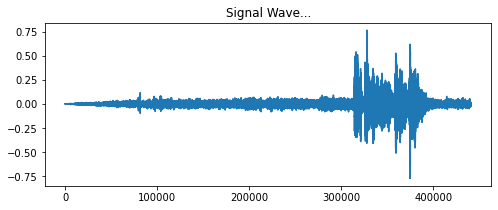

mean power2.1023556e-05
deviation0.049716488


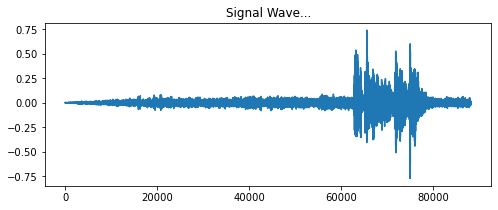

In [7]:
presentAliasingAudio(data_voice, rate_voice, 5)


# Music

8.335681e-05
mean power8.335681e-05
deviation0.22924751


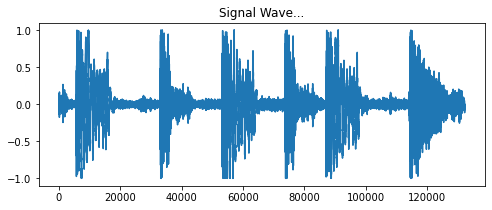

mean power9.604941e-05
deviation0.22960061


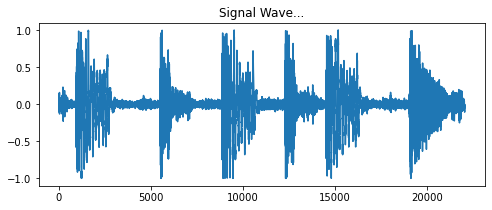

In [8]:
presentAliasingAudio(data_music, rate_music, 6)

# Chirp

0.0017638963583933547
mean power0.0017638963583933547
deviation0.7066624998339741


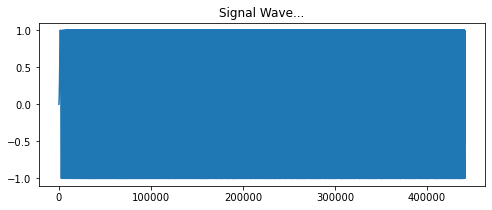

mean power0.001805475048011058
deviation0.7055058715078711


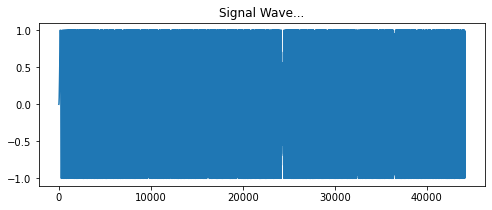

In [9]:
Fs = 44100
t = np.arange(0, 10, 1/Fs)
f = 200
data_chirp = np.sin(2*np.pi*f*t*t)
rate_chirp = Fs
presentAliasingAudio(data_chirp, rate_chirp, 10)

In [10]:
Fs = 5      # the sampling frequency
F_plot = 100  # the frequency used for plotting the time-continuous curves
T = 2       # the time-span we'll cover
t = np.arange(0, T, 1/Fs)  # the sample times
t_plot = np.arange(0, t.max(), 1/F_plot)  # time instants for plotting


def showAlias(f1):
    plt.gcf().clear()
    f2 = min(f1, Fs-f1)  # determine the alias frequency
    xt1 = lambda t: np.cos(2*np.pi*f1*t) # create both sine-functions
    xt2 = lambda t: np.cos(2*np.pi*f2*t)
    
    # plot the signals
    plt.subplot(121)
    plt.plot(t_plot, xt1(t_plot), 'b-', lw=2, label='input signal')
    plt.stem(t, xt1(t), label='sampled points')
    plt.plot(t_plot, xt2(t_plot), 'g-', label='after sampling')
    plt.ylim((-1.1, 1.5)); plt.grid(True)
    plt.legend(fontsize=8)
    plt.xlabel('$t$'); plt.ylabel('$x(t), x[n]$')
    
    # plot the spectrum of the signals
    t_freq = np.arange(0, 20*T, 1/F_plot) 
    x1 = xt1(t_freq)
    x2 = xt2(t_freq)
    X1 = np.fft.fftshift(np.fft.fft(x1, 8*len(x1))) / len(x1)
    X2 = np.fft.fftshift(np.fft.fft(x2, 8*len(x1))) / len(x2)
    f = np.linspace(-F_plot/2, F_plot/2, len(X1), endpoint=False)
    plt.subplot(122)
    plt.plot(f, abs(X1), lw=2, label='input')
    plt.plot(f, abs(X2), label='after sampling')
    plt.legend(loc='upper left', fontsize=8)
    plt.xlim((-Fs, Fs))
    plt.axvline(-Fs/2, color='k', ls='--', lw=2)
    plt.axvline(Fs/2, color='k', ls='--', lw=2)
    plt.ylim((-0.1, 1.1))
    plt.grid(True)
    plt.text(x=2.5, y=0.8, s='$f_{in}=%.2f$\n$f_{out}=%.2f$' % (f1, f2), bbox=dict(facecolor='white'))
    plt.xlabel('$f$'); plt.ylabel('$|X(f)|$')
    plt.show()

In [12]:
plt.figure()
interact(showAlias, f1=(0,5., 0.01));

interactive(children=(FloatSlider(value=2.5, description='f1', max=5.0, step=0.01), Output()), _dom_classes=('…

In the left figure, the time-domain input signal (blue) with frequency $f_0$, the sampled points (blue dots) and the sine wave with the same sampling points but with frequency $0<f_1<F_s/2$ (green) are shown. In the right figure, the spectrum of both sine-waves is presented. As long as the input signal in blue is within $0<f_0<F_s/2$, the green curve is on top of the blue. But, as soon as $f_0>Fs/2$, the frequency of the green curve decreases, when the input frequency increases. **The input signal of too high frequency $f_0>F_s/2$ is mapped to a lower frequency $F_s-f_0$ in the output**. 

This is also exactly what we heard in the third sound example of aliasing, i.e. the chirp function.  As soon, as the frequency of the sine went above the Nyquist frequency, the aliasing kicks in and the actually played frequencie decreases. Let us repeat this here for convenience:

0.0017638963583933547
mean power0.0017638963583933547
deviation0.7066624998339741


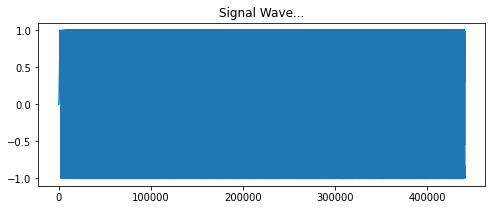

mean power0.001805475048011058
deviation0.7055058715078711


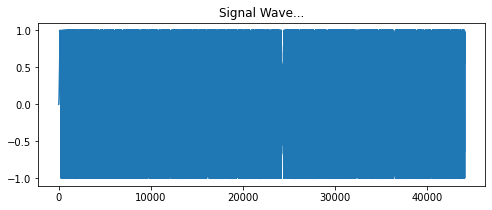

In [13]:
presentAliasingAudio(data_chirp, rate_chirp, 10)

Now, with the designed anti-aliasing filter, we can go ahead and implement our downsampling with and without anti-aliasing filtering:

Finally, here's the code to load the presented audio pieces from the internet:

And eventually, the URLs and calls to actually load the audio from the WWW:

# Summary

> - Aliasing occurs during downsampling a digital or sampling an analog signal
> - The name *Aliasing* stems from the fact that several different frequencies on the original signal are mapped to the same sampled sequence, i.e. creating ambiguity in the sampled signal.
> - Aliasing can be mitigated by application of a low-pass filter before downsampling. The low-pass filter removes all frequencies above half the Nyquist-frequency and thus inhibits aliasing of high-frequencies into the lower frequencies. 
> - In audio, aliasing can have different sounds, depending on the originating signal. 